# Predicting Taxi Ride Duration

This project was for my class at UC Berkeley called *Data 100 (Principles and Techniques of Data Science)*. I created a regression model that predicts the travel time of a taxi ride in New York.

Goals of this project include:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit linear regression models.
- Embedding linear regression as a component in a more complex model. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

The goal right now is to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Data Selection

In this part, I limited the data to trips that began and ended on Manhattan Island ([map](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488)) using a SQL query to load the `taxi` table from `taxi.db`.

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

In [2]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

query = '''
SELECT *
FROM taxi
WHERE pickup_lon BETWEEN -74.03 AND -73.75 AND dropoff_lon BETWEEN -74.03 AND -73.75 AND pickup_lat BETWEEN 40.6 AND 40.88 AND dropoff_lat BETWEEN 40.6 AND 40.88
'''

all_taxi = pd.read_sql(query, conn)
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there. The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

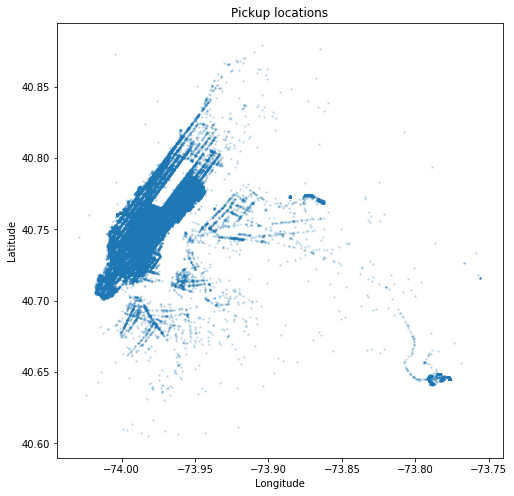

In [3]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

## Data Cleaning


The DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour.

In [4]:
clean_taxi = all_taxi[all_taxi.passengers > 0]
clean_taxi = clean_taxi[all_taxi.distance > 0]
clean_taxi = clean_taxi[all_taxi.duration >= 60]
clean_taxi = clean_taxi[all_taxi.duration <= 3600]
clean_taxi = clean_taxi[all_taxi.distance/(all_taxi.duration/3600) <= 100]
clean_taxi

C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
...,...,...,...,...,...,...,...,...,...
97687,2016-01-31 02:59:16,2016-01-31 03:09:23,-73.997391,40.721027,-73.978447,40.745277,1,2.17,607
97688,2016-01-14 22:48:10,2016-01-14 22:51:27,-73.988037,40.718761,-73.983337,40.726162,1,0.60,197
97689,2016-01-08 04:46:37,2016-01-08 04:50:12,-73.984390,40.754978,-73.985909,40.751820,4,0.79,215
97690,2016-01-31 12:55:54,2016-01-31 13:01:07,-74.008675,40.725979,-74.009598,40.716003,1,0.85,313


The DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within a polygon that defines the boundaries of [Manhattan Island](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

The vertices of this polygon are defined in `manhattan.csv` as (latitude, longitude) pairs, which are [published here](https://gist.github.com/baygross/5430626). An efficient way to test if a point is contained within a polygon is [described on this page](http://alienryderflex.com/polygon/).

In [5]:
polygon = pd.read_csv('manhattan.csv')

def in_manhattan(x, y):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    lat = list(polygon['lat'])
    lon = list(polygon['lon'])

    j = len(lat) - 1
    oddNodes = False
    
    for i in range(0, j+1):
        #if ((lat[i] < y <= lat[j]) or (lat[j] < y <= lat[i])) and (lon[i] <= x or lon[j] <= x):
        if (lat[i] < y and lat[j] >= y or lat[j] < y and lat[i] >= y):
            if (lon[i] + (y - lat[i]) / (lat[j] - lat[i]) * (lon[j] - lon[i]) < x):
                oddNodes = not oddNodes
        j = i
    return oddNodes
    
dropoff = clean_taxi.apply(lambda x: in_manhattan(x.dropoff_lon, x.dropoff_lat), axis=1)
pickup= clean_taxi.apply(lambda x: in_manhattan(x.pickup_lon, x.pickup_lat), axis=1)

manhattan_taxi = clean_taxi.loc[(dropoff == True) & (pickup == True), :]
manhattan_taxi

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812
...,...,...,...,...,...,...,...,...,...
97687,2016-01-31 02:59:16,2016-01-31 03:09:23,-73.997391,40.721027,-73.978447,40.745277,1,2.17,607
97688,2016-01-14 22:48:10,2016-01-14 22:51:27,-73.988037,40.718761,-73.983337,40.726162,1,0.60,197
97689,2016-01-08 04:46:37,2016-01-08 04:50:12,-73.984390,40.754978,-73.985909,40.751820,4,0.79,215
97690,2016-01-31 12:55:54,2016-01-31 13:01:07,-74.008675,40.725979,-74.009598,40.716003,1,0.85,313


A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

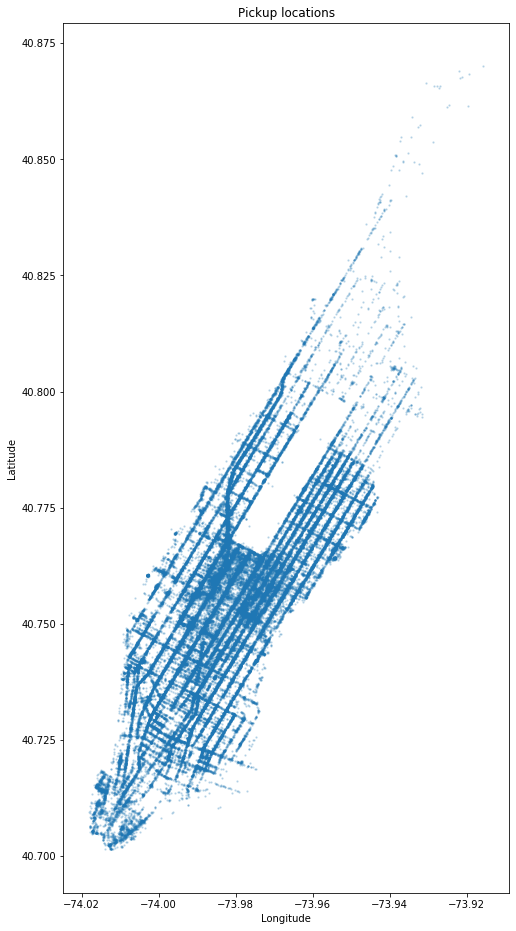

In [6]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

In [7]:
number = len(all_taxi)
percent = 100 - len(clean_taxi)/number * 100
number2 = len(manhattan_taxi)
print(f"Of the original {number} trips, {percent}% of anomolous trips were removed thorugh data cleaning, \n and then the {number2} trips within Manhattan were selected for further analysis.")


Of the original 97692 trips, 1.2764607132620824% of anomolous trips were removed thorugh data cleaning, 
 and then the 82800 trips within Manhattan were selected for further analysis.


## Exploratory Data Analysis

In this part, I chose which days to include as training data in your regression model. 

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

In [9]:
manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi['pickup_datetime']).dt.date
manhattan_taxi.head()

C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


Here is a data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016.

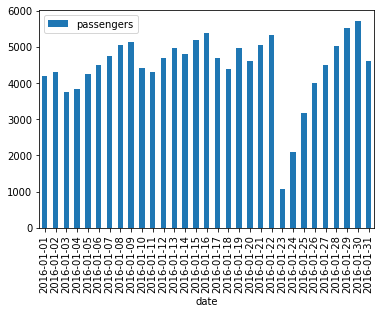

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped = manhattan_taxi.groupby(['date']).sum().drop(['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance', 'duration'], axis = 1)
grouped.plot.bar()

Here is a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. 

In [11]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



## Feature Engineering

In this part, I created a design matrix (i.e., feature matrix) for your linear regression model. I decided to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

It's best to split the data into training and test sets now, so I can look into the data in detail in order to define features.

In [12]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


This box plot that compares the distributions of taxi trip durations for each day **using `train` only**.

Visually shown in the boxplot, there seems to be a repeating pattern between 2016-01-04 to 2016-01-10 and 2016-01-10 to 2016-01-17. Between these two groups, taxi durations closer to the weekend were shorter than the taxi durations during weekdays.

[Text(0, 0, '2016-01-04'),
 Text(0, 0, '2016-01-05'),
 Text(0, 0, '2016-01-06'),
 Text(0, 0, '2016-01-07'),
 Text(0, 0, '2016-01-08'),
 Text(0, 0, '2016-01-09'),
 Text(0, 0, '2016-01-10'),
 Text(0, 0, '2016-01-11'),
 Text(0, 0, '2016-01-12'),
 Text(0, 0, '2016-01-13'),
 Text(0, 0, '2016-01-14'),
 Text(0, 0, '2016-01-15'),
 Text(0, 0, '2016-01-16'),
 Text(0, 0, '2016-01-17'),
 Text(0, 0, '2016-01-19'),
 Text(0, 0, '2016-01-20'),
 Text(0, 0, '2016-01-21'),
 Text(0, 0, '2016-01-22'),
 Text(0, 0, '2016-01-27'),
 Text(0, 0, '2016-01-28'),
 Text(0, 0, '2016-01-29'),
 Text(0, 0, '2016-01-30'),
 Text(0, 0, '2016-01-31')]

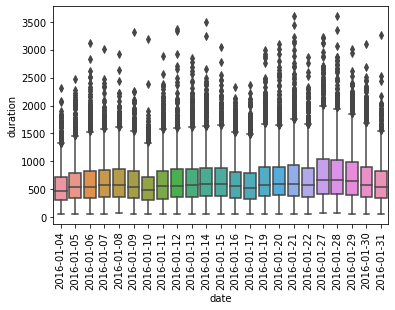

In [13]:
sortt = pd.DataFrame(train)
sortt.sort_values(by = ['date'], inplace = True)
figure2 = sns.boxplot(x = 'date', y = 'duration', data = sortt)
figure2.set_xticklabels(figure2.get_xticklabels(), rotation = 90)

Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.

In [15]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-21 18:02:20
dropoff_datetime    2016-01-21 18:27:54
pickup_lon                     -73.9942
pickup_lat                       40.751
dropoff_lon                    -73.9637
dropoff_lat                     40.7711
passengers                            1
distance                           2.77
duration                           1534
date                         2016-01-21
hour                                 18
day                                   3
weekend                               0
period                                3
speed                           6.50065
Name: 16548, dtype: object

Used `sns.distplot` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours).

It looks like the time of day is associated with the average speed of a taxi ride.

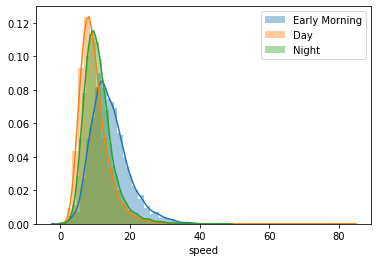

In [17]:
cleaned = train.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'passengers', 'distance','duration', 'date', 'hour', 'day', 'weekend'], axis = 1)
figure4 = sns.distplot(cleaned[cleaned['period'] == 1]['speed'], label = 'Early Morning')
figure4 = sns.distplot(cleaned[cleaned['period'] == 2]['speed'], label = 'Day')
figure4 = sns.distplot(cleaned[cleaned['period'] == 3]['speed'], label = 'Night')
figure4.legend()

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude).

I added a `region` column to `train` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

In [18]:
D = train[['pickup_lon', 'pickup_lat']]
pca_n = len(D)
pca_means = np.mean(D)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)
first_pc = pd.DataFrame((u*s)[:, 0:1])[0]
first_pc
train.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
train

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed,region
16548,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652,0
10750,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636,2
10957,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317,0
89932,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143,NaN
54687,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54216,2016-01-30 08:36:42,2016-01-30 08:48:51,-73.975388,40.782051,-73.971741,40.750389,1,3.00,729,2016-01-30,8,5,1,2,14.814815,NaN
9108,2016-01-27 20:44:05,2016-01-27 20:47:55,-73.984451,40.761623,-73.989998,40.756695,1,0.70,230,2016-01-27,20,2,0,3,10.956522,2
79891,2016-01-13 15:07:27,2016-01-13 15:12:06,-73.954193,40.770229,-73.945229,40.775219,1,0.77,279,2016-01-13,15,2,0,2,9.935484,NaN
1245,2016-01-04 05:46:00,2016-01-04 05:52:29,-73.984055,40.725250,-74.001221,40.731049,1,1.00,389,2016-01-04,5,0,0,1,9.254499,2


In [19]:
# Find the first principal component
D = train[['pickup_lon', 'pickup_lat']]
pca_n = len(D)
pca_means = np.mean(D)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lon', 'pickup_lat']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X @ vt[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

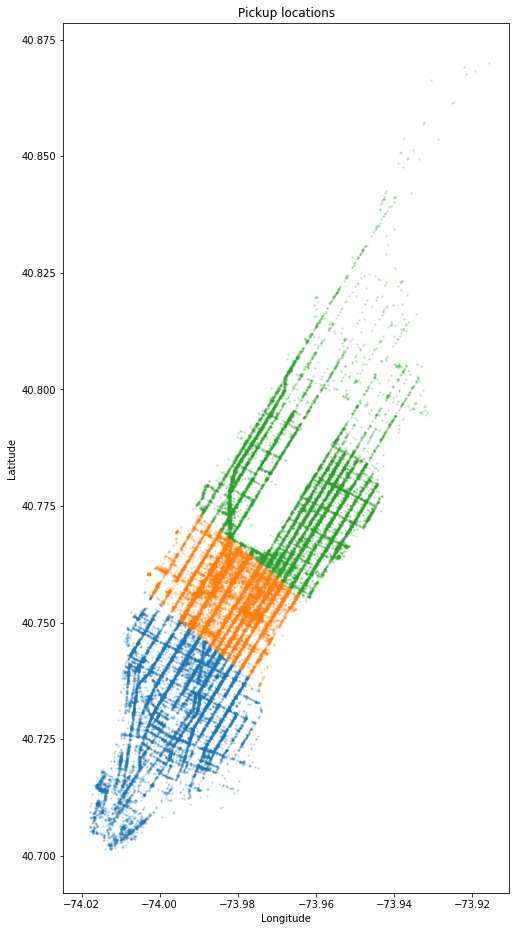

In [20]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

Used sns.distplot to create an overlaid histogram comparing the distribution of speeds for nighttime taxi rides (6pm-12am) in the three different regions defined above. 

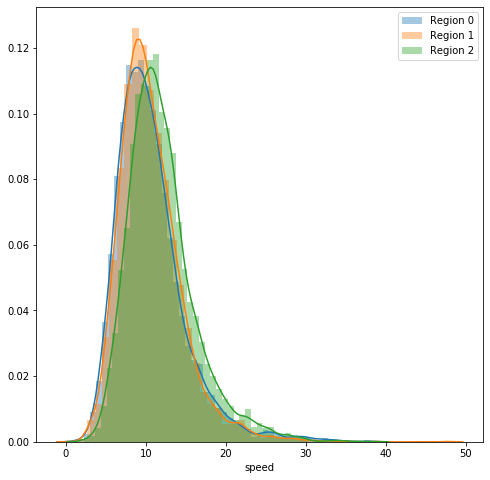

In [40]:
plt.figure(figsize=(8,8))
sns.distplot(train.loc[ (train['region'] == 0) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 0')
sns.distplot(train.loc[ (train['region'] == 1) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 1')
sns.distplot(train.loc[ (train['region'] == 2) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 2')
plt.legend()
plt.show();

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [21]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 16548, dtype: float64

## Model Selection

In this part, I selected a regression model to predict the duration of a taxi ride.

`constant_rmse` is the root mean squared error on the test set for a constant model that always predicts the mean duration of all training set taxi rides.

In [22]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

constant_rmse = rmse(test['duration'] - np.mean(train['duration']))
constant_rmse

399.1437572352677

`simple_rmse` is the root mean squared error on the test set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(train[['distance']], train['duration'])
pred = model.predict(test[['distance']])

simple_rmse = rmse(test['duration'] - pred)
simple_rmse

276.7841105000337

`linear_rmse` is the root mean squared error on the test set for a linear regression model fitted to the training set without regularization, using the design matrix defined by the `design_matrix` function.

In [24]:
model = LinearRegression()
desma = design_matrix(train)

model2 = model.fit(desma, train['duration'])

desma2 = design_matrix(test)

pred = model.predict(desma2)

linear_rmse = rmse(test['duration'] - pred)
linear_rmse

255.19146631882788

For each possible value of `period`, I fit an unregularized linear regression model to the subset of the training set in that `period`.  `period_rmse` is the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters.

In [25]:
np.unique(train['period'])

model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    selected = train.loc[train.period == v] #selects training rows that have specific period
    selecteddesma = design_matrix(selected) #uses function on selected training rows
    
    selected2 = test.loc[test.period == v] #selects test rows that have specific period
    selecteddesma2 = design_matrix(selected2) #uses function on selected test rows
    
    model = model.fit(selecteddesma, selected['duration']) #fits training design_matrix
    pred = model.predict(selecteddesma2) #predicts on test
    
    errors.extend(selected2['duration'] - pred)


period_rmse = rmse(np.array(errors))
period_rmse

246.62868831165176

This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

The `period` regression model could possibly outperform linear regression model, even when the design matrix of the latter includes one feature for each possible hour.
Periods are specific groups of hours (early morning, day, and night). In the plot below, we can see that there is a lot of green/blue dots (nighttime rides) positioned around the center of the map while orange dots (day rides) positioned around the outside. So when considering predicting duration, the period model allows for certain rides that are similar to predict duration better than just a model that includes every hour.

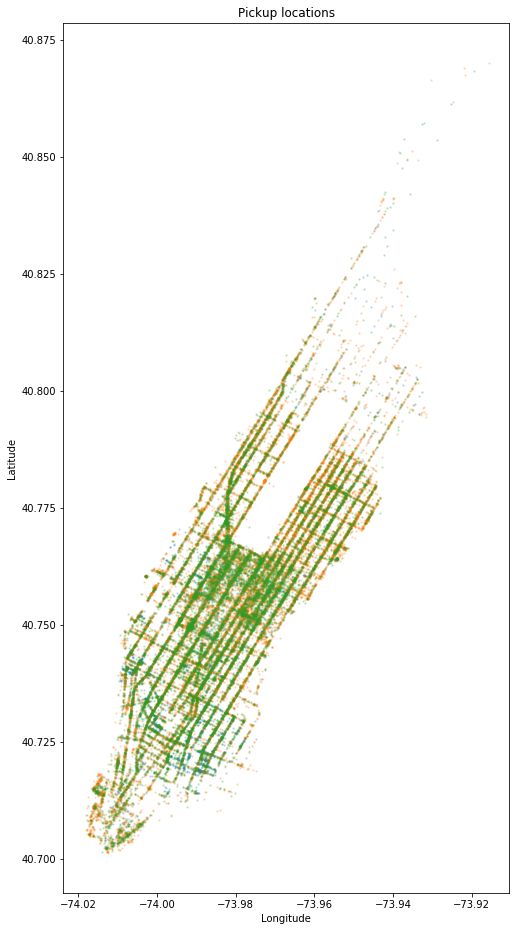

In [26]:
plt.figure(figsize=(8, 16))
for i in [1, 2, 3]:
    pickup_scatter(train[train['period'] == i])

Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

 `speed_rmse` is the root mean squared error in the **duration** predicted by a model that first predicts speed as a linear combination of features from the `design_matrix` function, fitted on the training set, then predicts duration from the predicted speed and observed distance.

In [27]:
model = LinearRegression()
model = model.fit(design_matrix(train), train['speed'])
pred = model.predict(design_matrix(test))

duration = (test['distance'] / pred) * 3600

speed_rmse = rmse(test['duration'] - duration)
speed_rmse

243.0179836851497

`tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

Including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

In [39]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    predictions_duration = (observations['distance'] * 3600) / predictions
    return predictions_duration - observations['duration']

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train.loc[v_train[c] == v]
            v_test = v_test.loc[v_test[c] == v]
            
        model.fit(design_matrix(v_train), v_train.loc[:, 'speed'])
        pred = np.array(model.predict(design_matrix(v_test)))
        
        eps = speed_error(pred, v_test).tolist()
        errors = errors + eps
    return errors

tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 246.62868831165176 
Speed: 226.90793945018314


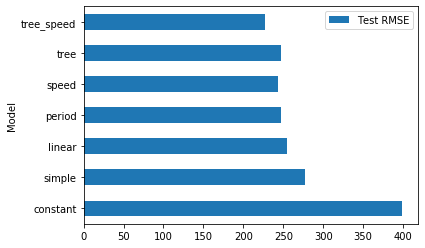

In [29]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

## Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the project:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. How would you do that?
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would you select which variables to include in a decision tree instead of just using them all?
- Your models use the observed distance as an input, but the distance is only observed after the ride is over. How could you estimate the distance from the pick-up and drop-off locations?
- How would you incorporate traffic data into the model?